# Miniproject 3: Poem Generation

### Download Data

In [ ]:
import requests
import matplotlib.pyplot as plt

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


### Importing packages \& Preprocessing

In [ ]:
import os
import re
import random
import urllib.request
import numpy as np
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
import pickle
import torch
from tqdm import tqdm

#==============================================================================================#
# Shakespeare Sonnet Processing Functions
#==============================================================================================#

def preprocess_text(text):
    """Preprocess the text for HMM training."""
    print(f"Original text length: {len(text)} characters")

    # Remove line numbers (like "1", "2" that denote sonnet numbers)
    text = re.sub(r'\n\s+\d+\s*\n', '\n\n', text)

    # Convert to lowercase
    text = text.upper()

    # Replace newlines with space and remove EOS tokens entirely
    # DELETE THE LINE THAT ADDS EOS TOKENS TO THE TEXT
    text = re.sub(r'\n', ' ', text)  # Just replace newlines with spaces, no EOS

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Remove punctuation (except apostrophes in words like "don't")
    text = re.sub(r'[^\w\s\']|(?<!\w)\'|\'\s', ' ', text)

    # Tokenize by splitting on whitespace
    tokens = text.split()

    return tokens

def prepare_sequences(tokens):
    """Convert tokens into training sequences."""
    # Use all tokens as a single sequence - no need to split by EOS
    sequences = [tokens]

    print(f"Number of sequences: {len(sequences)}")

    # Show some sample sequences
    if sequences:
        if len(sequences[0]) > 10:
            print(f"Sample sequence (first 10 words): {sequences[0][:10]}...")
        else:
            print(f"Sample sequence: {sequences[0]}")

    return sequences

def train_hmm_from_sequences(sequences, n_states=15, n_iters=10, use_gpu=True):
    """
    Train an HMM model using the provided sequences.

    Args:
        sequences: List of token sequences
        n_states: Number of hidden states
        n_iters: Number of training iterations
        use_gpu: Whether to use GPU acceleration if available

    Returns:
        model: Dictionary containing the HMM model and mappings
    """
    # Create vocabulary from all sequences
    all_tokens = [token for seq in sequences for token in seq]
    vocabulary = sorted(set(all_tokens))

    # Create mapping from tokens to indices and back
    token_to_idx = {token: idx for idx, token in enumerate(vocabulary)}
    idx_to_token = {idx: token for idx, token in enumerate(vocabulary)}

    # Convert sequences to numeric form for HMM training
    numeric_sequences = []
    for seq in sequences:
        numeric_seq = [token_to_idx[token] for token in seq]
        numeric_sequences.append(numeric_seq)

    # Train unsupervised HMM with progress bar
    print(f"Training HMM with {n_states} states and {n_iters} iterations...")
    print(f"GPU acceleration: {'enabled' if use_gpu and torch.cuda.is_available() else 'disabled'}")

    hmm_model = unsupervised_HMM(numeric_sequences, n_states, n_iters, use_gpu=use_gpu)
    hmm_model.idx_to_token = idx_to_token  # Store token mapping in the model

    # Package model and mappings
    model = {
        'hmm': hmm_model,
        'token_to_idx': token_to_idx,
        'idx_to_token': idx_to_token,
        'vocabulary': vocabulary,
        'n_states': n_states
    }

    return model

# Add simplified saving/loading functions that don't use pickle
def save_model_simple(model, filename):
    """
    Save model to a simple NumPy format instead of pickle.

    Args:
        model: The model dictionary to save
        filename: The filename without extension
    """
    hmm = model['hmm']
    token_to_idx = model['token_to_idx']

    # Convert dictionaries to arrays of tuples
    token_items = np.array(list(token_to_idx.items()), dtype=object)

    # Save using NumPy's compressed format
    np.savez_compressed(
        f"{filename}.npz",
        A=hmm.A,
        O=hmm.O,
        token_items=token_items,
        n_states=model['n_states']
    )
    print(f"Model saved to {filename}.npz")

def load_model_simple(filename):
    """
    Load model from the simple NumPy format.

    Args:
        filename: The filename without extension

    Returns:
        The loaded model dictionary
    """
    # Load the compressed data
    data = np.load(f"{filename}.npz", allow_pickle=True)

    # Reconstruct dictionaries
    token_to_idx = dict(data['token_items'])
    idx_to_token = {int(idx): token for token, idx in token_to_idx.items()}
    vocabulary = list(token_to_idx.keys())

    # Create HMM model
    hmm = HiddenMarkovModel(data['A'], data['O'])
    hmm.idx_to_token = idx_to_token  # Store token mapping in the model

    # Create the model dictionary
    model = {
        'hmm': hmm,
        'token_to_idx': token_to_idx,
        'idx_to_token': idx_to_token,
        'vocabulary': vocabulary,
        'n_states': int(data['n_states'])
    }

    print(f"Model loaded from {filename}.npz")
    return model

def load_syllable_dict(filepath):
    """
    Load the syllable dictionary from a file.

    Args:
        filepath: Path to the syllable dictionary file

    Returns:
        Dictionary mapping words to their syllable counts
    """
    syllable_dict = {}
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 2:
                    word = parts[0].lower()
                    # Extract only the numeric part for syllable count
                    # The last part could be a number or contain tags like 'E1'
                    last_part = parts[-1]

                    # If the last part is a pure number, use it
                    if last_part.isdigit():
                        syllables = int(last_part)
                    # If it has a tag like 'E1', extract the numeric part
                    elif len(parts) >= 3 and parts[-2].startswith('E') and parts[-1].isdigit():
                        syllables = int(parts[-1])
                    # If there's a tag in the last part (e.g., 'E1')
                    elif any(c.isdigit() for c in last_part):
                        # Extract only the digits
                        digits = ''.join(c for c in last_part if c.isdigit())
                        if digits:
                            syllables = int(digits)
                        else:
                            syllables = 1  # Default
                    else:
                        syllables = 1  # Default if no clear number

                    syllable_dict[word] = syllables
        print(f"Loaded syllable dictionary with {len(syllable_dict)} words")
    except Exception as e:
        print(f"Error loading syllable dictionary: {e}")

    return syllable_dict

# Implementing Models

## HMM Code

In [ ]:

# =============================================================================================#
# HMM Functions
# =============================================================================================#

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O, device=None):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
            device:     Device to use for tensor operations ('cuda' or 'cpu')
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''
        # For backward compatibility, we'll use numpy arrays by default
        self.use_gpu = device is not None and device == 'cuda' and torch.cuda.is_available()

        if self.use_gpu:
            self.device = 'cuda'
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")

            # Convert matrices to PyTorch tensors
            if isinstance(A, torch.Tensor):
                self.A = A.to(self.device)
            else:
                self.A = torch.tensor(A, dtype=torch.float32).to(self.device)

            if isinstance(O, torch.Tensor):
                self.O = O.to(self.device)
            else:
                self.O = torch.tensor(O, dtype=torch.float32).to(self.device)

            self.L = self.A.shape[0]
            self.D = self.O.shape[1]

            # Initialize start probabilities as uniform distribution
            self.A_start = torch.ones(self.L, dtype=torch.float32).to(self.device) / self.L
        else:
            # Use numpy arrays for better compatibility with existing code
            print(f"Using CPU (numpy arrays)")
            self.device = 'cpu'

            # Convert to numpy arrays if needed
            if isinstance(A, torch.Tensor):
                self.A = A.cpu().numpy()
            else:
                self.A = np.array(A)

            if isinstance(O, torch.Tensor):
                self.O = O.cpu().numpy()
            else:
                self.O = np.array(O)

            self.L = len(self.A)
            self.D = len(self.O[0])

            # Initialize start probabilities as uniform distribution
            self.A_start = np.ones(self.L) / self.L

    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          probs[1][i] = self.A_start[i] * self.O[i][x[0]]
          seqs[1][i] = str(i)


        for d in range(2, M + 1):

          for curr_state in range(self.L):
            max_prob = float("-inf")
            best_seq = ""

            for prev_state in range(self.L):
              prob = probs[d-1][prev_state] * self.A[prev_state][curr_state] * self.O[curr_state][x[d-1]]
              if prob >= max_prob:
                max_prob = prob
                best_seq = seqs[d-1][prev_state] + str(curr_state)

            probs[d][curr_state] = max_prob
            seqs[d][curr_state] = best_seq

        max_seq = seqs[M][np.argmax(probs[M])]
        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          alphas[1][i] = self.A_start[i] * self.O[i][x[0]]

        for d in range(2, M + 1):

          for curr_state in range(self.L):
            prob = 0
            for prev_state in range(self.L):
              prob += (self.O[curr_state][x[d-1]] * (alphas[d-1][prev_state] * self.A[prev_state][curr_state]))

            alphas[d][curr_state] = prob

          if normalize:
            denom = np.sum(alphas[d])
            alphas[d] = [alpha/denom for alpha in alphas[d]]


        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          betas[M][i] = 1

        for d in range(M - 1, -1, -1):

          for curr_state in range(self.L):
            prob = 0
            for next_state in range(self.L):
                if d == 0:
                  prob += (betas[d+1][next_state] * self.A_start[next_state] * self.O[next_state][x[d]])
                else:
                  prob += (betas[d+1][next_state] * self.A[curr_state][next_state] * self.O[next_state][x[d]])

            betas[d][curr_state] = prob

          if normalize:
            denom = np.sum(betas[d])
            betas[d] = [beta/denom for beta in betas[d]]

        return betas

    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''
        # Add a progress bar for training iterations
        for i in tqdm(range(N_iters), desc="Training HMM", unit="iteration"):
            A_numer = np.zeros((self.L, self.L))
            A_denom = np.zeros((self.L, self.L))
            O_numer = np.zeros((self.L, self.D))
            O_denom = np.zeros((self.L, self.D))

            for x in X:
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)
                M = len(x)

                for d in range(1, M + 1):
                    prob_OAd = np.array([alphas[d][curr_state] * betas[d][curr_state] for curr_state in range(self.L)])
                    prob_OAd /= np.sum(prob_OAd)

                    for curr_state in range(self.L):
                        O_numer[curr_state][x[d-1]] += prob_OAd[curr_state]
                        O_denom[curr_state] += prob_OAd[curr_state]
                        if d != M:
                            A_denom[curr_state] += prob_OAd[curr_state]

                for d in range(1, M):
                    prob_An = np.array([[alphas[d][curr_state] \
                                      * self.O[next_state][x[d]] \
                                      * self.A[curr_state][next_state] \
                                      * betas[d+1][next_state] \
                                      for next_state in range(self.L)] \
                                      for curr_state in range(self.L)])
                    prob_An /= np.sum(prob_An)

                    for curr_state in range(self.L):
                        for next_state in range(self.L):
                            A_numer[curr_state][next_state] += prob_An[curr_state][next_state]

            # Convert numpy arrays to the appropriate type (tensor or numpy)
            if isinstance(self.A, torch.Tensor):
                self.A = torch.tensor(A_numer / A_denom, device=self.device)
                self.O = torch.tensor(O_numer / O_denom, device=self.device)
            else:
                self.A = A_numer / A_denom
                self.O = O_numer / O_denom


    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. This implementation NEVER returns EOS tokens.

        Arguments:
            M:          Length of the emission to generate.
            seed:       Optional random seed for reproducibility
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''
        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []
        eos_token_idx = None

        # Find the index of the EOS token in the vocabulary if it exists
        if hasattr(self, 'idx_to_token') and '<eos>' in self.idx_to_token.values():
            eos_token_idx = [idx for idx, token in self.idx_to_token.items() if token == '<eos>']
            if eos_token_idx:
                eos_token_idx = eos_token_idx[0]

        # Initialize Random Start State
        state = np.random.randint(0, self.L)

        # Generate M valid (non-EOS) tokens
        while len(emission) < M:
            # Get emission probabilities for current state
            probs = self.O[state].copy()

            # Set probability of EOS token to zero if identified
            if eos_token_idx is not None and eos_token_idx < len(probs):
                probs[eos_token_idx] = 0
                # Renormalize if needed
                if np.sum(probs) > 0:
                    probs = probs / np.sum(probs)
                else:
                    # If all probability mass was on EOS, pick a random token
                    probs = np.ones(self.D)
                    if eos_token_idx < len(probs):
                        probs[eos_token_idx] = 0
                    probs = probs / np.sum(probs)

            # Generate emission based on adjusted probabilities
            emitted_token = np.random.choice(list(range(self.D)), p=probs)

            # Skip EOS tokens entirely (backup check)
            if eos_token_idx is not None and emitted_token == eos_token_idx:
                # This should not happen given the zero probability, but just in case
                continue

            emission.append(emitted_token)
            states.append(state)

            # Transition to next state
            state = np.random.choice(list(range(self.L)), p=self.A[state])

        return emission, states

def unsupervised_HMM(X, n_states, N_iters, seed=None, use_gpu=True):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        N_iters:    The number of iterations to train on.
        seed:       The random seed for reproducible result.
        use_gpu:    Whether to use GPU acceleration if available.
    '''
    # Set random seeds for reproducibility
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

    # Determine whether to use GPU based on availability and user preference
    device = 'cuda' if use_gpu and torch.cuda.is_available() else None

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Initialize matrices based on device
    if device == 'cuda':
        # Use PyTorch for GPU
        A = torch.rand((L, L), device=device)
        A = A / A.sum(dim=1, keepdim=True)

        O = torch.rand((L, D), device=device)
        O = O / O.sum(dim=1, keepdim=True)
    else:
        # Use NumPy for CPU
        A = np.random.random((L, L))
        for i in range(L):
            A[i] = A[i] / np.sum(A[i])

        O = np.random.random((L, D))
        for i in range(L):
            O[i] = O[i] / np.sum(O[i])

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O, device=device)
    HMM.unsupervised_learning(X, N_iters)


    return HMM

# HMM Poem Functions

## Tuning the Number of Hidden States

In [ ]:
def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()



[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


Loading Shakespeare text...
Loading syllable dictionary...
Parsing syllable dictionary...
Loaded syllable dictionary with 3205 words
'being' has syllable count: [1, 2]
'devil' has syllable count: 2
'power' has syllable count: 1
Found existing model. Load it? (y/n): n
Enter number of hidden states as a comma-separated list (e.g., 10,15,20): 5, 10, 15, 20
Enter number of training iterations (recommended: 50-200): 20
Original text length: 98029 characters
Original text length: 98029 characters
Number of tokens after preprocessing: 17666
First 20 tokens: ['1', 'FROM', 'FAIREST', 'CREATURES', 'WE', 'DESIRE', 'INCREASE', 'THAT', 'THEREBY', "BEAUTY'S", 'ROSE', 'MIGHT', 'NEVER', 'DIE', 'BUT', 'AS', 'THE', 'RIPER', 'SHOULD', 'BY']
Number of sequences: 1
Sample sequence (first 10 words): ['1', 'FROM', 'FAIREST', 'CREATURES', 'WE', 'DESIRE', 'INCREASE', 'THAT', 'THEREBY', "BEAUTY'S"]...
Training HMM with 5 states and 20 iterations...
GPU acceleration: disabled
Using CPU (numpy arrays)


Training HMM: 100%|██████████| 20/20 [01:06<00:00,  3.31s/iteration]


Training HMM with 10 states and 20 iterations...
GPU acceleration: disabled
Using CPU (numpy arrays)


Training HMM: 100%|██████████| 20/20 [03:02<00:00,  9.11s/iteration]


Training HMM with 15 states and 20 iterations...
GPU acceleration: disabled
Using CPU (numpy arrays)


Training HMM: 100%|██████████| 20/20 [05:54<00:00, 17.75s/iteration]


Training HMM with 20 states and 20 iterations...
GPU acceleration: disabled
Using CPU (numpy arrays)


Training HMM: 100%|██████████| 20/20 [09:52<00:00, 29.64s/iteration]


Model saved to shakespeare_hmm.npz

Generating Shakespearean sonnet with traditional structure...

Shakespearean sonnet for 5 hidden states:
--------------------------------------------------------------------------------
When sweet doth by usury rose all of,
Idol thousand should whate'er unions forget,
Am his and love and poor past me spent love,
From to conscience yet not mourn own brings yet, 

Your liberty that this dost seems him my,
Cold and a fool as within up side are,
At as upon to nor graces and by,
The works added that of thy the ever, 

My true tuned of one from removed so see,
Gaze thy he song him seeming may their she,
Seasoned look rights weeds precious when the the thee,
Then astonished happies and so three, 

Happier part I the I I when only,
Men's his o say sad beauty purity.
--------------------------------------------------------------------------------



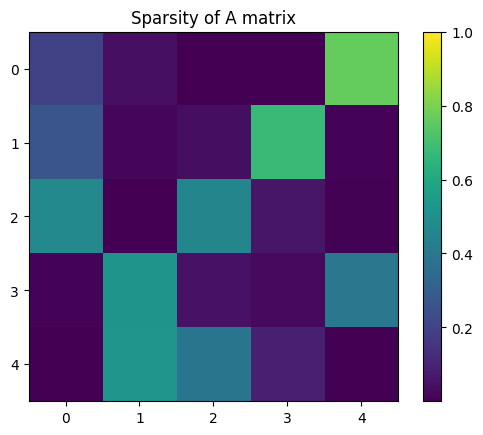


Shakespearean sonnet for 10 hidden states:
--------------------------------------------------------------------------------
Happy to and dearths truths and no if dead,
Hath that I faint and fools ride that to are,
Petty of most and not cold beauty fled,
Blot than abused and my upon change for, 

It me whom thou nor their judgement his my,
Sooner captive and worst store at growth of,
Raised thy whence and time eternal new I,
I every not gentle art how that love, 

Untrimmed men you is excuse seals halt see,
Former him not in love make be never,
Hours grows them not have duty is't miles be,
Nature the thought prove informer fairer, 

On goodness you translate sway'st so then shows,
Locked fair but thee your woman's true spring love owes.
--------------------------------------------------------------------------------



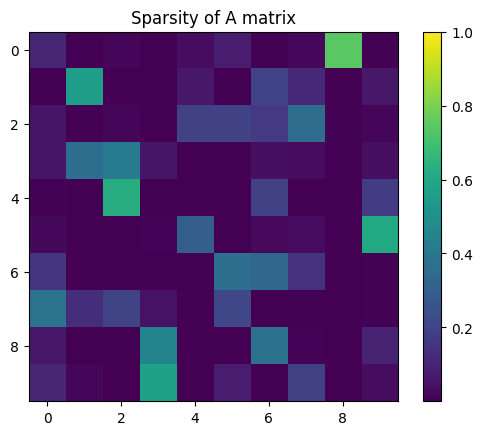


Shakespearean sonnet for 15 hidden states:
--------------------------------------------------------------------------------
That such of frowns my which knife were love dead,
Are past should huge thy love showers doth by of,
Faces will eye's to the yet kings sweet red,
The is children lips flatterer please love, 

Not of awards that set where health to my,
When stays effect sickness dear alchemy,
I fault night with one both from excuse by,
With skill are true I reason doth body, 

For this strange whose vile will youngly so own,
Windows and with beated lived alas she,
Love I thee down are not my doom lends stone,
Spend yet are by remember since now free, 

Re haply survey unmoved my say,
To my absent his by love hope bare they.
--------------------------------------------------------------------------------



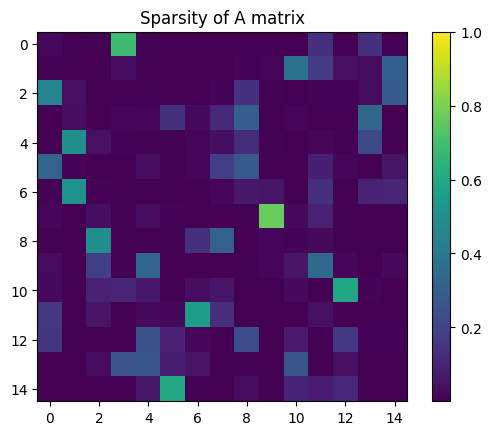


Shakespearean sonnet for 20 hidden states:
--------------------------------------------------------------------------------
Aloft I me in do appetite are,
My most thou so dull fair o'er live of my,
To in one make others sight wished neither,
When thou blind one nor tears cold my they why, 

Public by grows on day fair out by of,
Flies incertainties or wealth dwell lovers,
And thou dost if so it thy twixt gives love,
To whom nay when thee sure of from feathers, 

Pain injuries wear good as though heavy,
Keep I sweet who and accents be within,
No by to farther heart grown into be,
Thee distraction of this me losses in, 

Leese making hath thou to it self ocean,
World one betwixt is forbear neglect heaven.
--------------------------------------------------------------------------------



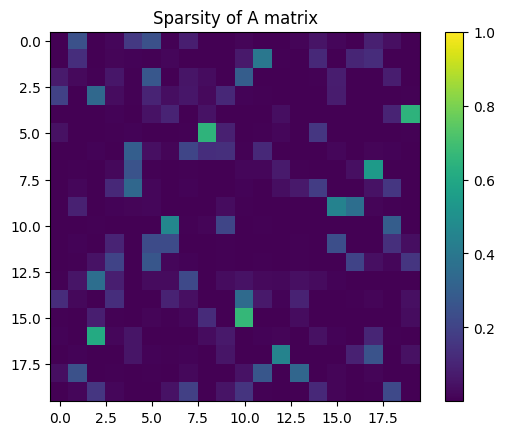

In [ ]:
# =============================================================================================#
# Poem Functions
# =============================================================================================#

import numpy as np
import os
import pickle

import sys
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

cmu_dict = cmudict.dict()


def get_top_words_for_state(model, state_idx, top_n=10):
    """Get the top words associated with a specific hidden state."""
    hmm = model['hmm']
    idx_to_token = model['idx_to_token']

    emission_probs = hmm.O[state_idx]

    # Get indices of top words
    top_indices = np.argsort(emission_probs)[-top_n:][::-1]

    # Get corresponding words and probabilities
    top_words = [(idx_to_token[idx], emission_probs[idx]) for idx in top_indices if idx < len(idx_to_token)]

    return top_words

def save_model(model, filename):
    """Save model to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")

def load_model(filename):
    """Load model from a pickle file."""
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model

def get_word_syllables(word, syllable_dict, is_line_end=False):
    """
    Get the syllable count for a word, considering special cases like E notation.

    Args:
        word: The word to check
        syllable_dict: Dictionary of syllable counts
        is_line_end: Whether this word appears at the end of a line

    Returns:
        Number of syllables for the word
    """
    # Get the entry from the dictionary
    entry = syllable_dict.get(word.lower(), None)

    # If word not found, default to 1
    if entry is None:
        return 1

    # If it's a simple number, return it
    if isinstance(entry, int):
        return entry

    # Handle the special 'E' notation - words that have a different syllable count at line end
    if isinstance(entry, dict) and 'E' in entry and is_line_end:
        return entry['E']
    elif isinstance(entry, dict) and 'normal' in entry:
        return entry['normal']

    # If it's a multi-syllable option, take the first one
    if isinstance(entry, list) and entry:
        return entry[0]

    # Default case
    return 1

def parse_syllable_dict(filepath):
    """
    Parse the syllable dictionary, handling the special E notation and multiple syllable counts.

    Args:
        filepath: Path to the syllable dictionary file

    Returns:
        Dictionary mapping words to their syllable counts with special cases
    """
    syllable_dict = {}
    print("Parsing syllable dictionary...")

    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue

                word = parts[0].lower()

                # Handle entries with E notation (different syllable count at line end)
                if 'E' in parts[1:]:
                    e_index = parts.index('E')
                    if e_index < len(parts) - 1 and parts[e_index + 1].isdigit():
                        end_count = int(parts[e_index + 1])

                        # Find normal syllable count (after E notation or last in list)
                        normal_count = None
                        for p in parts[1:e_index]:
                            if p.isdigit():
                                normal_count = int(p)
                                break

                        if normal_count is None and e_index + 2 < len(parts) and parts[e_index + 2].isdigit():
                            normal_count = int(parts[e_index + 2])

                        # Default normal count if not found
                        if normal_count is None:
                            for p in parts[1:]:
                                if p.isdigit():
                                    normal_count = int(p)
                                    break

                        if normal_count is None:
                            normal_count = 1

                        syllable_dict[word] = {'E': end_count, 'normal': normal_count}
                    continue

                # Handle regular entries (one or more syllable counts)
                counts = [int(p) for p in parts[1:] if p.isdigit()]
                if counts:
                    if len(counts) == 1:
                        syllable_dict[word] = counts[0]
                    else:
                        syllable_dict[word] = counts
                else:
                    syllable_dict[word] = 1  # Default

        print(f"Loaded syllable dictionary with {len(syllable_dict)} words")

        # Check a few examples
        test_words = ['being', 'devil', 'power']
        for word in test_words:
            if word in syllable_dict:
                print(f"'{word}' has syllable count: {syllable_dict[word]}")

    except Exception as e:
        print(f"Error parsing syllable dictionary: {e}")
        import traceback
        traceback.print_exc()

    return syllable_dict

def count_syllables(line, syllable_dict, is_complete_line=True):
    """
    Count total syllables in a line of text using the syllable dictionary.
    Handles special cases for end-of-line words.

    Args:
        line: The line of text
        syllable_dict: Dictionary mapping words to syllable counts
        is_complete_line: Whether this is a complete line (affects last word counting)

    Returns:
        Total number of syllables in the line
    """
    words = line.split()
    if not words:
        return 0

    total = 0

    for i, word in enumerate(words):
        # Remove any non-alphabetic characters
        clean_word = ''.join(c for c in word if c.isalpha())
        if not clean_word:
            continue

        # Check if this is the last word in the line
        is_line_end = (i == len(words) - 1) and is_complete_line

        # Get syllable count for this word
        syllables = get_word_syllables(clean_word, syllable_dict, is_line_end)
        total += syllables

    return total

def get_rhyme_part(pron):
    """
    Extracts the rhyming part of a pronunciation:
    - Last stressed vowel and everything after.
    - Falls back to the last two phonemes if no stress is found.

    Args:
        pron (list): List of phonemes from the CMU dictionary.

    Returns:
        tuple: Rhyming part of the pronunciation.
    """
    stress_indices = [i for i, phoneme in enumerate(pron) if any(c.isdigit() for c in phoneme)]
    if stress_indices:
        return tuple(pron[stress_indices[-1]:])  # Last stressed vowel + everything after
    return tuple(pron[-2:])  # Fallback: last two phonemes

def find_words_for_rhyme_set(hmm, idx_to_token):
    """
    Finds a set of words for rhyming in a sonnet, ensuring phonetic rhyming.

    Args:
        hmm: HMM model.
        idx_to_token: Mapping from indices to tokens.
        num_words: Number of unique rhyme sets needed.
        max_attempts: Maximum attempts to find words.

    Returns:
        dict: Dictionary mapping rhyme keys ('a', 'b', 'c', etc.) to rhyming words.
    """
    rhyme_words = {}

    # Generate a batch of words
    emission, _ = hmm.generate_emission(300)
    words = [idx_to_token[e] for e in emission if e < len(idx_to_token) and idx_to_token[e].isalpha()]

    # Remove duplicates and filter to words in the CMU dictionary
    words = list(set(w.lower() for w in words if w.lower() in cmu_dict))

    # Rhyme set labels
    rhyme_patterns = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

    for pattern in rhyme_patterns:
        rhyme_words[pattern] = []

        while words:
            primary_word = words.pop(0)
            primary_prons = cmu_dict[primary_word]

            # Get the rhyme signature (set of possible rhyming parts)
            rhyme_signatures = {get_rhyme_part(pron) for pron in primary_prons}

            # Find words that share a valid rhyme signature
            rhyming_candidates = [
                word for word in words
                if any(get_rhyme_part(pron) in rhyme_signatures for pron in cmu_dict[word])
            ]

            if rhyming_candidates:
                chosen_rhyme = random.choice(rhyming_candidates)
                rhyme_words[pattern].extend([primary_word, chosen_rhyme])
                words.remove(chosen_rhyme)
                break  # Move to the next rhyme set

    return rhyme_words

def generate_line_with_ending(hmm, idx_to_token, syllable_dict, ending_word, target_syllables=10, max_attempts=40):
    """
    Generate a line that ends with a specific word and has approximately the target syllable count.

    Args:
        hmm: The HMM model
        idx_to_token: Mapping from indices to tokens
        syllable_dict: Dictionary mapping words to syllable counts
        ending_word: The word to end the line with
        target_syllables: Target syllable count for the line
        max_attempts: Maximum generation attempts

    Returns:
        A line with the specified ending word and approximately the target syllable count
    """
    # Lower-case the ending word for consistency
    ending_word = ending_word.lower()

    # Get syllable count of the ending word when at line end
    ending_syllables = get_word_syllables(ending_word, syllable_dict, True)
    remaining_syllables = target_syllables - ending_syllables

    # If the ending word has too many syllables, just use it alone
    if remaining_syllables <= 0:
        return ending_word

    best_line = ""
    best_diff = float('inf')

    for _ in range(max_attempts):
        # Generate more tokens than we need
        emission, _ = hmm.generate_emission(15)
        words = [idx_to_token[e].lower() for e in emission if e < len(idx_to_token)]  # Ensure lowercase

        # Try different prefix lengths
        for length in range(1, min(len(words) + 1, 10)):
            prefix_words = words[:length]
            line = ' '.join(prefix_words + [ending_word])

            # Count syllables in the line
            syllable_count = count_syllables(line, syllable_dict)
            diff = abs(syllable_count - target_syllables)

            # Keep track of the closest match
            if diff < best_diff:
                best_diff = diff
                best_line = line

                # Perfect match!
                if diff == 0:
                    return best_line

    return best_line if best_line else ending_word

def capitalize_first_letter(line):
    """Capitalize the first letter of a line."""
    if not line:
        return line
    line = line[0].upper() + line[1:]
    for i in range(1, len(line)):
        if line[i-1:i+2] == ' i ':
            line = line[:i] + 'I' + line[i+1:]
    if line[-2:] == ' i':
        line = line[:-1] + 'I'
    return line

def generate_shakespearean_sonnet(model, syllable_dict):
    """
    Generate a Shakespearean sonnet with the traditional abab-cdcd-efef-gg rhyme scheme
    and approximately 10 syllables per line.

    Args:
        model: The trained model dictionary
        syllable_dict: Dictionary of syllable counts

    Returns:
        A formatted sonnet as a string
    """
    hmm = model['hmm']
    idx_to_token = model['idx_to_token']

    # Shakespearean sonnet rhyme scheme
    rhyme_scheme = ['a', 'b', 'a', 'b', 'c', 'd', 'c', 'd', 'e', 'f', 'e', 'f', 'g', 'g']

    # Find words for each rhyme pattern
    rhyme_sets = find_words_for_rhyme_set(hmm, idx_to_token)

    for pattern, words in rhyme_sets.items():
        # Convert to lowercase for display
        words_display = [w.lower() for w in words]
    lines = []
    for i, pattern in enumerate(rhyme_scheme):
        # Get a word for this rhyme pattern
        if pattern in rhyme_sets and rhyme_sets[pattern]:
            rhyme_word = rhyme_sets[pattern].pop(0) if rhyme_sets[pattern] else ""

            # Generate a line with this ending word
            line = generate_line_with_ending(hmm, idx_to_token, syllable_dict, rhyme_word)

            # Capitalize the first letter - traditional for sonnets
            line = capitalize_first_letter(line)
            if i == len(rhyme_scheme) - 1:
                # Last line doesn't need a comma
                lines.append(line + '.')
            elif i == 3 or i == 7 or i == 11:
                lines.append(line + ', \n')
            else:
                lines.append(line + ',')
        else:
            # Fallback if we don't have a rhyme word
            emission, _ = hmm.generate_emission(10)
            words = [idx_to_token[e].lower() for e in emission if e < len(idx_to_token)]  # Ensure lowercase
            line = ' '.join(words[:min(len(words), 10)])

            # Capitalize the first letter
            line = capitalize_first_letter(line)
            lines.append(line + ',')

    # Check syllable counts for verification
    for i, line in enumerate(lines):
        syllables = count_syllables(line, syllable_dict)

    return '\n'.join(lines)

def main():
    print("Loading Shakespeare text...")
    if not os.path.exists('shakespeare.txt'):
        print("Error: shakespeare.txt not found. Please make sure it's in the current directory.")
        sys.exit(1)

    with open('shakespeare.txt', 'r', encoding='utf-8') as file:
        shakespeare_text = file.read()

    print("Loading syllable dictionary...")
    syllable_dict = {}
    if os.path.exists('syllable_dict.txt'):
        syllable_dict = parse_syllable_dict('syllable_dict.txt')
    else:
        print("Warning: syllable_dict.txt not found. Syllable-based features will be disabled.")


    # Choose whether to train a new model or load an existing one
    model_path = 'shakespeare_hmm'
    model_file_npz = f"{model_path}.npz"
    model_file_pkl = f"{model_path}.pkl"

    if (os.path.exists(model_file_npz) or os.path.exists(model_file_pkl)) and \
       input(f"Found existing model. Load it? (y/n): ").lower() == 'y':
        bool = 0
        if os.path.exists(model_file_npz):
            print(f"Loading model from {model_file_npz}...")
            models = [load_model_simple(model_path)]
        else:
            print(f"Loading model from {model_file_pkl}...")
            models = [load_model(model_file_pkl)]
    else:
        bool = 1
        states_input = input("Enter number of hidden states as a comma-separated list (e.g., 10,15,20): ") or "15"
        n_states = [int(state) for state in states_input.split(',')]
        n_iters = int(input("Enter number of training iterations (recommended: 50-200): ") or "10")

        # Preprocess and train
        tokens = preprocess_text(shakespeare_text)

        # Display stats about preprocessing
        print(f"Original text length: {len(shakespeare_text)} characters")
        print(f"Number of tokens after preprocessing: {len(tokens)}")
        print(f"First 20 tokens: {tokens[:20]}")

        sequences = prepare_sequences(tokens)
        models = []
        for n in n_states:
            model = train_hmm_from_sequences(sequences, n_states=n, n_iters=n_iters)
            models.append(model)

        # Save the model using the simpler format
        save_model_simple(models[-1], model_path)

    # Generate a Shakespearean sonnet if we have a syllable dictionary
    if syllable_dict:
        print("\nGenerating Shakespearean sonnet with traditional structure...")
        try:
            for n, model in enumerate(models):
                sonnet = generate_shakespearean_sonnet(model, syllable_dict)
                if bool:
                    print(f"\nShakespearean sonnet for {n_states[n]} hidden states:")

                else:
                    print(f"\nShakespearean sonnet:")

                print(f"{'-'*80}")
                print(sonnet)
                print(f"{'-'*80}")
                print()
                # print("Transition matrix")
                visualize_sparsities(model["hmm"], O_max_cols=200)
                # print("\n Observation matrix")
                # visualize_sparsities(model["hmm"].O, O_max_cols=50)

        except Exception as e:
            print(f"Could not generate structured sonnet: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("\nGenerating Shakespearean sonnet with traditional structure...")
        try:
            sonnet = generate_shakespearean_sonnet(model, cmu_dict)
            print(f"\nShakespearean sonnet:")
            print(f"{'-'*80}")
            print(sonnet)
            print(f"{'-'*80}")
        except Exception as e:
            print(f"Could not generate structured sonnet: {e}")
            import traceback
            traceback.print_exc()


main()

## Piazza Poem

In [ ]:
# =============================================================================================#
# Poem Functions
# =============================================================================================#

import numpy as np
import os
import pickle

import sys
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

cmu_dict = cmudict.dict()


def get_top_words_for_state(model, state_idx, top_n=10):
    """Get the top words associated with a specific hidden state."""
    hmm = model['hmm']
    idx_to_token = model['idx_to_token']

    emission_probs = hmm.O[state_idx]

    # Get indices of top words
    top_indices = np.argsort(emission_probs)[-top_n:][::-1]

    # Get corresponding words and probabilities
    top_words = [(idx_to_token[idx], emission_probs[idx]) for idx in top_indices if idx < len(idx_to_token)]

    return top_words

def save_model(model, filename):
    """Save model to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")

def load_model(filename):
    """Load model from a pickle file."""
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model

def get_word_syllables(word, syllable_dict, is_line_end=False):
    """
    Get the syllable count for a word, considering special cases like E notation.

    Args:
        word: The word to check
        syllable_dict: Dictionary of syllable counts
        is_line_end: Whether this word appears at the end of a line

    Returns:
        Number of syllables for the word
    """
    # Get the entry from the dictionary
    entry = syllable_dict.get(word.lower(), None)

    # If word not found, default to 1
    if entry is None:
        return 1

    # If it's a simple number, return it
    if isinstance(entry, int):
        return entry

    # Handle the special 'E' notation - words that have a different syllable count at line end
    if isinstance(entry, dict) and 'E' in entry and is_line_end:
        return entry['E']
    elif isinstance(entry, dict) and 'normal' in entry:
        return entry['normal']

    # If it's a multi-syllable option, take the first one
    if isinstance(entry, list) and entry:
        return entry[0]

    # Default case
    return 1

def parse_syllable_dict(filepath):
    """
    Parse the syllable dictionary, handling the special E notation and multiple syllable counts.

    Args:
        filepath: Path to the syllable dictionary file

    Returns:
        Dictionary mapping words to their syllable counts with special cases
    """
    syllable_dict = {}
    print("Parsing syllable dictionary...")

    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue

                word = parts[0].lower()

                # Handle entries with E notation (different syllable count at line end)
                if 'E' in parts[1:]:
                    e_index = parts.index('E')
                    if e_index < len(parts) - 1 and parts[e_index + 1].isdigit():
                        end_count = int(parts[e_index + 1])

                        # Find normal syllable count (after E notation or last in list)
                        normal_count = None
                        for p in parts[1:e_index]:
                            if p.isdigit():
                                normal_count = int(p)
                                break

                        if normal_count is None and e_index + 2 < len(parts) and parts[e_index + 2].isdigit():
                            normal_count = int(parts[e_index + 2])

                        # Default normal count if not found
                        if normal_count is None:
                            for p in parts[1:]:
                                if p.isdigit():
                                    normal_count = int(p)
                                    break

                        if normal_count is None:
                            normal_count = 1

                        syllable_dict[word] = {'E': end_count, 'normal': normal_count}
                    continue

                # Handle regular entries (one or more syllable counts)
                counts = [int(p) for p in parts[1:] if p.isdigit()]
                if counts:
                    if len(counts) == 1:
                        syllable_dict[word] = counts[0]
                    else:
                        syllable_dict[word] = counts
                else:
                    syllable_dict[word] = 1  # Default

        print(f"Loaded syllable dictionary with {len(syllable_dict)} words")

        # Check a few examples
        test_words = ['being', 'devil', 'power']
        for word in test_words:
            if word in syllable_dict:
                print(f"'{word}' has syllable count: {syllable_dict[word]}")

    except Exception as e:
        print(f"Error parsing syllable dictionary: {e}")
        import traceback
        traceback.print_exc()

    return syllable_dict

def count_syllables(line, syllable_dict, is_complete_line=True):
    """
    Count total syllables in a line of text using the syllable dictionary.
    Handles special cases for end-of-line words.

    Args:
        line: The line of text
        syllable_dict: Dictionary mapping words to syllable counts
        is_complete_line: Whether this is a complete line (affects last word counting)

    Returns:
        Total number of syllables in the line
    """
    words = line.split()
    if not words:
        return 0

    total = 0

    for i, word in enumerate(words):
        # Remove any non-alphabetic characters
        clean_word = ''.join(c for c in word if c.isalpha())
        if not clean_word:
            continue

        # Check if this is the last word in the line
        is_line_end = (i == len(words) - 1) and is_complete_line

        # Get syllable count for this word
        syllables = get_word_syllables(clean_word, syllable_dict, is_line_end)
        total += syllables

    return total

def get_rhyme_part(pron):
    """
    Extracts the rhyming part of a pronunciation:
    - Last stressed vowel and everything after.
    - Falls back to the last two phonemes if no stress is found.

    Args:
        pron (list): List of phonemes from the CMU dictionary.

    Returns:
        tuple: Rhyming part of the pronunciation.
    """
    stress_indices = [i for i, phoneme in enumerate(pron) if any(c.isdigit() for c in phoneme)]
    if stress_indices:
        return tuple(pron[stress_indices[-1]:])  # Last stressed vowel + everything after
    return tuple(pron[-2:])  # Fallback: last two phonemes

def find_words_for_rhyme_set(hmm, idx_to_token):
    """
    Finds a set of words for rhyming in a sonnet, ensuring phonetic rhyming.

    Args:
        hmm: HMM model.
        idx_to_token: Mapping from indices to tokens.
        num_words: Number of unique rhyme sets needed.
        max_attempts: Maximum attempts to find words.

    Returns:
        dict: Dictionary mapping rhyme keys ('a', 'b', 'c', etc.) to rhyming words.
    """
    rhyme_words = {}

    # Generate a batch of words
    emission, _ = hmm.generate_emission(300)
    words = [idx_to_token[e] for e in emission if e < len(idx_to_token) and idx_to_token[e].isalpha()]

    # Remove duplicates and filter to words in the CMU dictionary
    words = list(set(w.lower() for w in words if w.lower() in cmu_dict))

    # Rhyme set labels
    rhyme_patterns = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

    for pattern in rhyme_patterns:
        rhyme_words[pattern] = []

        while words:
            primary_word = words.pop(0)
            primary_prons = cmu_dict[primary_word]

            # Get the rhyme signature (set of possible rhyming parts)
            rhyme_signatures = {get_rhyme_part(pron) for pron in primary_prons}

            # Find words that share a valid rhyme signature
            rhyming_candidates = [
                word for word in words
                if any(get_rhyme_part(pron) in rhyme_signatures for pron in cmu_dict[word])
            ]

            if rhyming_candidates:
                chosen_rhyme = random.choice(rhyming_candidates)
                rhyme_words[pattern].extend([primary_word, chosen_rhyme])
                words.remove(chosen_rhyme)
                break  # Move to the next rhyme set

    return rhyme_words

def generate_line_with_ending(hmm, idx_to_token, syllable_dict, ending_word, target_syllables=10, max_attempts=40):
    """
    Generate a line that ends with a specific word and has approximately the target syllable count.

    Args:
        hmm: The HMM model
        idx_to_token: Mapping from indices to tokens
        syllable_dict: Dictionary mapping words to syllable counts
        ending_word: The word to end the line with
        target_syllables: Target syllable count for the line
        max_attempts: Maximum generation attempts

    Returns:
        A line with the specified ending word and approximately the target syllable count
    """
    # Lower-case the ending word for consistency
    ending_word = ending_word.lower()

    # Get syllable count of the ending word when at line end
    ending_syllables = get_word_syllables(ending_word, syllable_dict, True)
    remaining_syllables = target_syllables - ending_syllables

    # If the ending word has too many syllables, just use it alone
    if remaining_syllables <= 0:
        return ending_word

    best_line = ""
    best_diff = float('inf')

    for _ in range(max_attempts):
        # Generate more tokens than we need
        emission, _ = hmm.generate_emission(15)
        words = [idx_to_token[e].lower() for e in emission if e < len(idx_to_token)]  # Ensure lowercase

        # Try different prefix lengths
        for length in range(1, min(len(words) + 1, 10)):
            prefix_words = words[:length]
            line = ' '.join(prefix_words + [ending_word])

            # Count syllables in the line
            syllable_count = count_syllables(line, syllable_dict)
            diff = abs(syllable_count - target_syllables)

            # Keep track of the closest match
            if diff < best_diff:
                best_diff = diff
                best_line = line

                # Perfect match!
                if diff == 0:
                    return best_line

    return best_line if best_line else ending_word

def capitalize_first_letter(line):
    """Capitalize the first letter of a line."""
    if not line:
        return line
    line = line[0].upper() + line[1:]
    for i in range(1, len(line)):
        if line[i-1:i+2] == ' i ':
            line = line[:i] + 'I' + line[i+1:]
    if line[-2:] == ' i':
        line = line[:-1] + 'I'
    return line

def generate_shakespearean_sonnet(model, syllable_dict):
    """
    Generate a Shakespearean sonnet with the traditional abab-cdcd-efef-gg rhyme scheme
    and approximately 10 syllables per line.

    Args:
        model: The trained model dictionary
        syllable_dict: Dictionary of syllable counts

    Returns:
        A formatted sonnet as a string
    """
    hmm = model['hmm']
    idx_to_token = model['idx_to_token']

    # Shakespearean sonnet rhyme scheme
    rhyme_scheme = ['a', 'b', 'a', 'b', 'c', 'd', 'c', 'd', 'e', 'f', 'e', 'f', 'g', 'g']

    # Find words for each rhyme pattern
    rhyme_sets = find_words_for_rhyme_set(hmm, idx_to_token)

    for pattern, words in rhyme_sets.items():
        # Convert to lowercase for display
        words_display = [w.lower() for w in words]
    lines = []
    for i, pattern in enumerate(rhyme_scheme):
        # Get a word for this rhyme pattern
        if pattern in rhyme_sets and rhyme_sets[pattern]:
            rhyme_word = rhyme_sets[pattern].pop(0) if rhyme_sets[pattern] else ""

            # Generate a line with this ending word
            line = generate_line_with_ending(hmm, idx_to_token, syllable_dict, rhyme_word)

            # Capitalize the first letter - traditional for sonnets
            line = capitalize_first_letter(line)
            if i == len(rhyme_scheme) - 1:
                # Last line doesn't need a comma
                lines.append(line + '.')
            elif i == 3 or i == 7 or i == 11:
                lines.append(line + ', \n')
            else:
                lines.append(line + ',')
        else:
            # Fallback if we don't have a rhyme word
            emission, _ = hmm.generate_emission(10)
            words = [idx_to_token[e].lower() for e in emission if e < len(idx_to_token)]  # Ensure lowercase
            line = ' '.join(words[:min(len(words), 10)])

            # Capitalize the first letter
            line = capitalize_first_letter(line)
            lines.append(line + ',')

    # Check syllable counts for verification
    for i, line in enumerate(lines):
        syllables = count_syllables(line, syllable_dict)

    return '\n'.join(lines)

def main():
    print("Loading Shakespeare text...")
    if not os.path.exists('shakespeare.txt'):
        print("Error: shakespeare.txt not found. Please make sure it's in the current directory.")
        sys.exit(1)

    with open('shakespeare.txt', 'r', encoding='utf-8') as file:
        shakespeare_text = file.read()

    print("Loading syllable dictionary...")
    syllable_dict = {}
    if os.path.exists('syllable_dict.txt'):
        syllable_dict = parse_syllable_dict('syllable_dict.txt')
    else:
        print("Warning: syllable_dict.txt not found. Syllable-based features will be disabled.")


    # Choose whether to train a new model or load an existing one
    model_path = 'shakespeare_hmm'
    model_file_npz = f"{model_path}.npz"
    model_file_pkl = f"{model_path}.pkl"

    if (os.path.exists(model_file_npz) or os.path.exists(model_file_pkl)) and \
       input(f"Found existing model. Load it? (y/n): ").lower() == 'y':
        bool = 0
        if os.path.exists(model_file_npz):
            print(f"Loading model from {model_file_npz}...")
            models = [load_model_simple(model_path)]
        else:
            print(f"Loading model from {model_file_pkl}...")
            models = [load_model(model_file_pkl)]
    else:
        bool = 1
        states_input = input("Enter number of hidden states as a comma-separated list (e.g., 10,15,20): ") or "15"
        n_states = [int(state) for state in states_input.split(',')]
        n_iters = int(input("Enter number of training iterations (recommended: 50-200): ") or "10")

        # Preprocess and train
        tokens = preprocess_text(shakespeare_text)

        # Display stats about preprocessing
        print(f"Original text length: {len(shakespeare_text)} characters")
        print(f"Number of tokens after preprocessing: {len(tokens)}")
        print(f"First 20 tokens: {tokens[:20]}")

        sequences = prepare_sequences(tokens)
        models = []
        for n in n_states:
            model = train_hmm_from_sequences(sequences, n_states=n, n_iters=n_iters)
            models.append(model)

        # Save the model using the simpler format
        save_model_simple(models[-1], model_path)

    # Generate a Shakespearean sonnet if we have a syllable dictionary
    if syllable_dict:
        print("\nGenerating Shakespearean sonnet with traditional structure...")
        try:
            for n, model in enumerate(models):
                sonnet = generate_shakespearean_sonnet(model, syllable_dict)
                if bool:
                    print(f"\nShakespearean sonnet for {n_states[n]} hidden states:")
                else:
                    print(f"\nShakespearean sonnet:")
                print(f"{'-'*80}")
                print(sonnet)
                print(f"{'-'*80}")
                print()
        except Exception as e:
            print(f"Could not generate structured sonnet: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("\nGenerating Shakespearean sonnet with traditional structure...")
        try:
            sonnet = generate_shakespearean_sonnet(model, cmu_dict)
            print(f"\nShakespearean sonnet:")
            print(f"{'-'*80}")
            print(sonnet)
            print(f"{'-'*80}")
        except Exception as e:
            print(f"Could not generate structured sonnet: {e}")
            import traceback
            traceback.print_exc()


main() # used 20 hidden states

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


Loading Shakespeare text...
Loading syllable dictionary...
Parsing syllable dictionary...
Loaded syllable dictionary with 3205 words
'being' has syllable count: [1, 2]
'devil' has syllable count: 2
'power' has syllable count: 1
Found existing model. Load it? (y/n): y
Loading model from shakespeare_hmm.npz...
Using CPU (numpy arrays)
Model loaded from shakespeare_hmm.npz

Generating Shakespearean sonnet with traditional structure...
Finding rhyming words for the sonnet...
Line 1: 10 syllables
Line 2: 10 syllables
Line 3: 10 syllables
Line 4: 10 syllables
Line 5: 10 syllables
Line 6: 10 syllables
Line 7: 10 syllables
Line 8: 10 syllables
Line 9: 10 syllables
Line 10: 10 syllables
Line 11: 10 syllables
Line 12: 10 syllables
Line 13: 10 syllables
Line 14: 10 syllables

Shakespearean sonnet:
--------------------------------------------------------------------------------
Thee is crushed of reap far done touches now,
And loathsome the take the sovereign title,
Of the not wires is my the shin

## RNN Code

1


## Additional Goal

## Visualization